In [1]:
!pip install pycocotools==2.0.5

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.5-cp310-cp310-linux_x86_64.whl size=109215 sha256=844fdfd5bd921c4635a43135f3fa022221def61e151b6b24a0aee4755bf7e9a0
  Stored in directory: /root/.cache/pip/wheels/d3/4a/98/7d5d35bf7390f5a21909a6d742cced42ae9aff6f1ed5d6bef7
Successfully built pycocotools


In [4]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [6]:
dataset_path = "/kaggle/input/image1000/New folder"

In [7]:
import os
import cv2
import torch
import copy
from pycocotools.coco import COCO
from torchvision import datasets  # Import the datasets module from torchvision

class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are required for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split  # train, valid, test
        self.coco = COCO(os.path.join(root, split, "kaggle/input/images/instances_val2017.json"))  # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [img_id for img_id in self.ids if (len(self._load_target(img_id)) > 0)]
    
    def _load_image(self, img_id: int):
        path = self.coco.loadImgs(img_id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_target(self, img_id):
        return self.coco.loadAnns(self.coco.getAnnIds(img_id))
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        image = self._load_image(img_id)
        target = self._load_target(img_id)
        target = copy.deepcopy(self._load_target(img_id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target]  # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = []  # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {}  # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        
        return image.div(255), targ  # scale images
    
    def __len__(self):
        return len(self.ids)

In [17]:
import os
import json
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO

class CustomDataset(Dataset):
    def __init__(self, json_file, img_dir, transforms=None):
        self.coco = COCO(json_file)
        self.img_dir = img_dir
        self.transforms = transforms
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        img_id = self.ids[index]
        img_info = self.coco.imgs[img_id]
        path = os.path.join(self.img_dir, img_info['file_name'])
        image = F.to_tensor(Image.open(path).convert("RGB"))

        ann_ids = self.coco.getAnnIds(img_id)
        annotations = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in annotations:
            boxes.append(ann['bbox'])
            labels.append(ann['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.ids)

# Load dataset
json_file = '/kaggle/input/images/instances_val2017.json'
img_dir = '/kaggle/input/images/val2017-20241107T150103Z-001/val2017'
dataset = CustomDataset(json_file=json_file, img_dir=img_dir)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

# Define the model with the correct backbone
backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])  # Remove the last two layers
backbone.out_channels = 2048  # Set the output channels

# Create the Faster R-CNN model
model = FasterRCNN(backbone, num_classes=91)  # Adjust num_classes as needed

# Move model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {losses.item():.4f}")

loading annotations into memory...
Done (t=21.25s)
creating index...
index created!


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 174, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 174, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 213, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [2]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-309tg5qd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-309tg5qd
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-w6elcjnh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-w6elcjnh
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
Dataset my_dataset unregistered.
Dataset my_dataset registered successfully!
Missing image files:
/kaggle/input/image1000/New folder/000000397133.jpg
/kaggle/input/image1000/New folder/000000252219.jpg
/kaggle/input/image1000/New folder/000000174482.jpg
/kaggle/input/image1000/New folder/000000403385.jpg
/kaggle/input/image1000/New folder/000000480985.jpg
/kaggle/input/image1000/New folder/000000458054.jpg
/kaggle/input/image1000/New folder/000000331352.jpg
/kaggle/input/image1000/New folder/000000296649.jpg
/kaggle/input/image1000/New folder/000000386912.jpg
/kaggle/input/image1000/New folder/000000502136.jpg
/k

[ WARN:0@805.145] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/image1000/New folder/000000201025.jpg'): can't open/read file: check file path/integrity


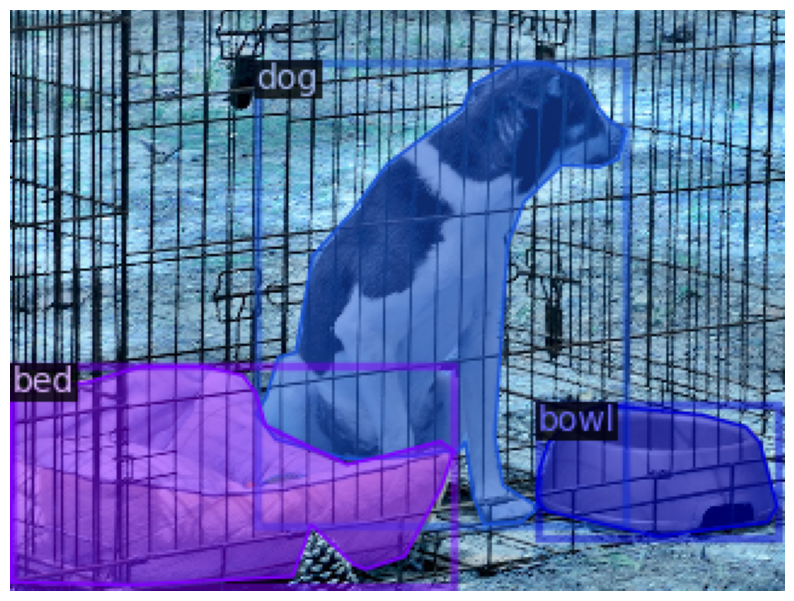

[ WARN:0@805.961] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/image1000/New folder/000000183675.jpg'): can't open/read file: check file path/integrity


AssertionError: Torch not compiled with CUDA enabled

In [9]:
# Install Detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Import necessary libraries
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.model_zoo import get_config_file, get_checkpoint_url
import os
import random
import cv2
import matplotlib.pyplot as plt
import json

# Step 1: Unregister Dataset if it Exists
def register_dataset(dataset_name, image_dir, json_path):
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)
        MetadataCatalog.remove(dataset_name)
        print(f"Dataset {dataset_name} unregistered.")
    
    register_coco_instances(dataset_name, {}, json_path, image_dir)
    print(f"Dataset {dataset_name} registered successfully!")

# Step 2: Debugging Missing Image Paths
def check_image_paths(json_path, image_dir):
    with open(json_path, "r") as f:
        data = json.load(f)
    missing_files = []
    for img in data["images"]:
        image_path = os.path.join(image_dir, img["file_name"])
        if not os.path.exists(image_path):
            missing_files.append(image_path)
    if missing_files:
        print("Missing image files:")
        for path in missing_files:
            print(path)
    else:
        print("All image files are present.")

# Step 3: Visualize the Dataset (Optional)
def visualize_samples(dataset_name, metadata, num_samples=3):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    for d in random.sample(dataset_dicts, num_samples):
        img = cv2.imread(d["file_name"])
        if img is None:
            print(f"Warning: Could not load image at {d['file_name']}. Skipping...")
            continue
        
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        
        # Display image using Matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.axis("off")
        plt.show()

# Step 4: Train Faster R-CNN
def train_faster_rcnn(dataset_name, output_dir, num_classes, max_iter=3000, batch_size=2):
    cfg = get_cfg()
    cfg.merge_from_file(
        get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    )
    cfg.DATASETS.TRAIN = (dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = batch_size
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.OUTPUT_DIR = output_dir

    os.makedirs(output_dir, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    print(f"Training completed. Model saved to {output_dir}")

# Step 5: Evaluate or Use the Model for Inference
def run_inference(cfg, image_path):
    predictor = DefaultPredictor(cfg)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}. Check the path.")
        return
    
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Display inference result using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

# Main Workflow
if __name__ == "__main__":
    dataset_name = "my_dataset"
    image_dir = "/kaggle/input/image1000/New folder"  # Update path to your images directory
    json_path = "/kaggle/input/images/instances_val2017.json"  # Update COCO JSON path
    output_dir = "/content/output_faster_rcnn"  # Save outputs in the working directory

    num_classes = 1  # Update based on your dataset
    max_iter = 500  # Number of iterations to train

    # Step 1: Register the dataset
    register_dataset(dataset_name, image_dir, json_path)

    # Step 2: Check dataset integrity
    check_image_paths(json_path, image_dir)

    # Step 3: Visualize samples from the dataset (Optional)
    metadata = MetadataCatalog.get(dataset_name)
    visualize_samples(dataset_name, metadata)

    # Step 4: Train Faster R-CNN
    train_faster_rcnn(dataset_name, output_dir, num_classes, max_iter)

    # Step 5: Inference example
    cfg = get_cfg()
    cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
    cfg.DATASETS.TEST = (dataset_name,)
    run_inference(cfg, "/kaggle/input/image1000/New folder/000000000724.jpg")  # Update path to test image


Dataset my_dataset registered successfully!
Missing image files:
/kaggle/input/image1000/New folder/000000397133.jpg
/kaggle/input/image1000/New folder/000000252219.jpg
/kaggle/input/image1000/New folder/000000174482.jpg
/kaggle/input/image1000/New folder/000000403385.jpg
/kaggle/input/image1000/New folder/000000480985.jpg
/kaggle/input/image1000/New folder/000000458054.jpg
/kaggle/input/image1000/New folder/000000331352.jpg
/kaggle/input/image1000/New folder/000000296649.jpg
/kaggle/input/image1000/New folder/000000386912.jpg
/kaggle/input/image1000/New folder/000000502136.jpg
/kaggle/input/image1000/New folder/000000491497.jpg
/kaggle/input/image1000/New folder/000000184791.jpg
/kaggle/input/image1000/New folder/000000348881.jpg
/kaggle/input/image1000/New folder/000000289393.jpg
/kaggle/input/image1000/New folder/000000522713.jpg
/kaggle/input/image1000/New folder/000000181666.jpg
/kaggle/input/image1000/New folder/000000143931.jpg
/kaggle/input/image1000/New folder/000000303818.jpg

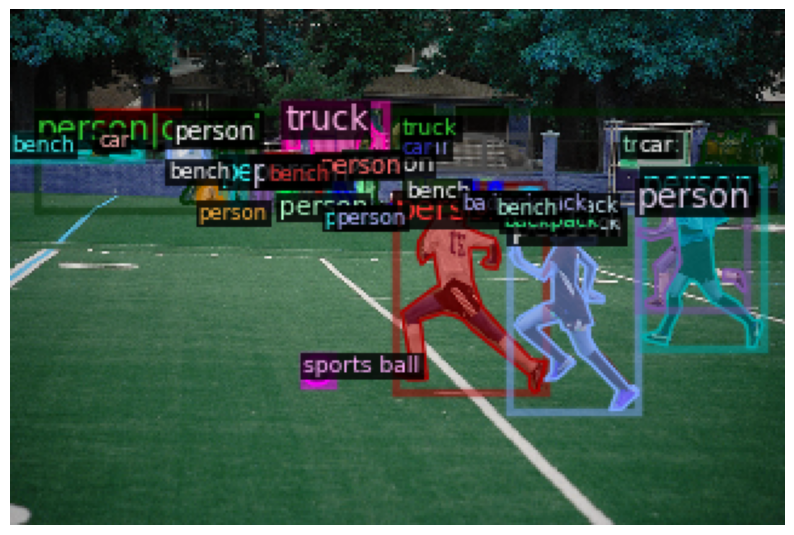

[ WARN:0@4498.097] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/image1000/New folder/000000420230.jpg'): can't open/read file: check file path/integrity


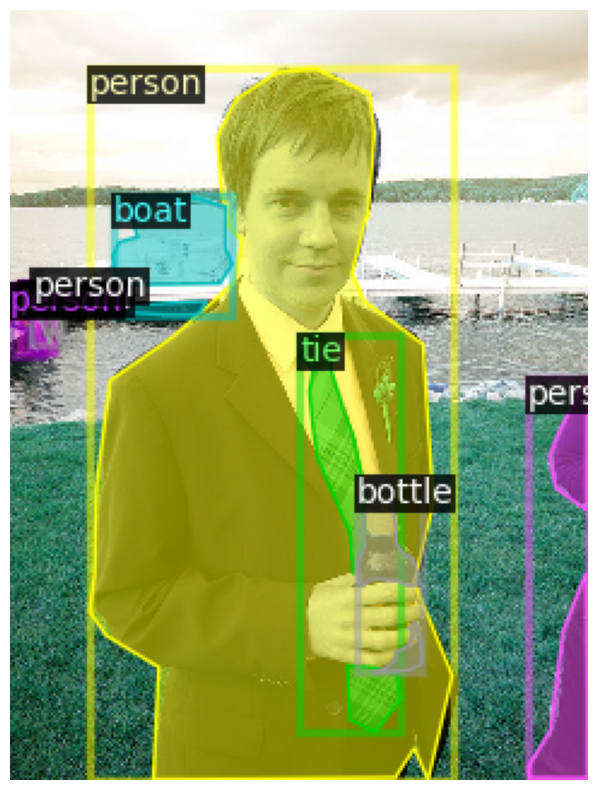

AssertionError: Torch not compiled with CUDA enabled

In [38]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.model_zoo import get_config_file, get_checkpoint_url
import os
import random
import cv2
import matplotlib.pyplot as plt
import json

# Step 1: Register the Dataset
def register_dataset(dataset_name, image_dir, json_path):
    register_coco_instances(dataset_name, {}, json_path, image_dir)
    print(f"Dataset {dataset_name} registered successfully!")

# Step 2: Debugging Missing Image Paths
def check_image_paths(json_path, image_dir):
    with open(json_path, "r") as f:
        data = json.load(f)
    missing_files = []
    for img in data["images"]:
        image_path = os.path.join(image_dir, img["file_name"])
        if not os.path.exists(image_path):
            missing_files.append(image_path)
    if missing_files:
        print("Missing image files:")
        for path in missing_files:
            print(path)
    else:
        print("All image files are present.")

# Step 3: Visualize the Dataset (Optional)
def visualize_samples(dataset_name, metadata, num_samples=3):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    for d in random.sample(dataset_dicts, num_samples):
        img = cv2.imread(d["file_name"])
        if img is None:
            print(f"Warning: Could not load image at {d['file_name']}. Skipping...")
            continue
        
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        
        # Display image using Matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.axis("off")
        plt.show()

# Step 4: Train Mask R-CNN
def train_mask_rcnn(dataset_name, output_dir, num_classes, max_iter=3000, batch_size=2):
    cfg = get_cfg()
    cfg.merge_from_file(
        get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    )
    cfg.DATASETS.TRAIN = (dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = batch_size
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.OUTPUT_DIR = output_dir

    os.makedirs(output_dir, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    print(f"Training completed. Model saved to {output_dir}")

# Step 5: Evaluate or Use the Model for Inference
def run_inference(cfg, image_path):
    predictor = DefaultPredictor(cfg)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}. Check the path.")
        return
    
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Display inference result using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

# Main Workflow
if __name__ == "__main__":
    dataset_name = "my_dataset"
    image_dir = "/kaggle/input/image1000/New folder"  # Update with the path to your image directory
    json_path = "/kaggle/input/images/instances_val2017.json"  # Update with your COCO JSON annotation path
    output_dir = "/kaggle/working/output_mask_rcnn"  # Save outputs in the working directory

    num_classes = 1  # Update based on your dataset
    max_iter = 500  # Number of iterations to train

    # Step 1: Register the dataset
    register_dataset(dataset_name, image_dir, json_path)

    # Step 2: Check dataset integrity
    check_image_paths(json_path, image_dir)

    # Step 3: Visualize samples from the dataset (Optional)
    metadata = MetadataCatalog.get(dataset_name)
    visualize_samples(dataset_name, metadata)

    # Step 4: Train Mask R-CNN
    train_mask_rcnn(dataset_name, output_dir, num_classes, max_iter)

    # Step 5: Inference example
    cfg = get_cfg()
    cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
    cfg.DATASETS.TEST = (dataset_name,)
    run_inference(cfg, "/kaggle/input/image1000/New folder/000000513524.jpg")  # Update with a test image path
